# Predict Volume of Pharmacy Claims and Prior Authorization Requests

In this notebook, we predict the volume of pharmacy claims and PA requests by month. We also assess the statistical significance of our results. 

In [508]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from warnings import simplefilter
from statsmodels.tools.sm_exceptions import ConvergenceWarning
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)
simplefilter(action='ignore', category=ConvergenceWarning)

## Load and prepare data

In [509]:
# Load Data
df_date=pd.read_csv("CoverMyMeds_data/dim_date.csv")
df_claim=pd.read_csv("CoverMyMeds_data/dim_claims.csv")
df_pa=pd.read_csv("CoverMyMeds_data/dim_pa.csv")
df_bridge=pd.read_csv("CoverMyMeds_data/bridge.csv")

# Clean data so all reject_code values are integers
df_claim['reject_code'] = df_claim.reject_code.fillna(0).astype(int)

# Merge the data frames
df_main = pd.merge(df_claim, df_bridge, on='dim_claim_id')
df_main = pd.merge(df_main, df_pa, how='left', on='dim_pa_id')
df_main = pd.merge(df_main, df_date, how='left', on='dim_date_id')

# split the data frames into two -- PA requested or not
df_main_wPA = df_main[~np.isnan(df_main.pa_approved)].copy()
df_main_noPA = df_main[np.isnan(df_main.pa_approved)].copy()

In [510]:
df_main.head()

,dim_claim_id,bin,drug,reject_code,pharmacy_claim_approved,dim_pa_id,dim_date_id,correct_diagnosis,tried_and_failed,contraindication,pa_approved,date_val,calendar_year,calendar_month,calendar_day,day_of_week,is_weekday,is_workday,is_holiday
0,1,417380,A,75,0,1.0,1,1.0,1.0,0.0,1.0,2017-01-01,2017,1,1,1,0,0,1
1,2,999001,A,0,1,NaN,1,NaN,NaN,NaN,NaN,2017-01-01,2017,1,1,1,0,0,1
2,3,417740,A,76,0,2.0,1,1.0,0.0,0.0,1.0,2017-01-01,2017,1,1,1,0,0,1
3,4,999001,A,0,1,NaN,1,NaN,NaN,NaN,NaN,2017-01-01,2017,1,1,1,0,0,1
4,5,417740,A,0,1,NaN,1,NaN,NaN,NaN,NaN,2017-01-01,2017,1,1,1,0,0,1


## Volume of Pharmacy Claims

In [511]:
claim_month = df_main_wPA.groupby(['calendar_year', 'calendar_month']).size()
claim_month = pd.DataFrame(claim_month, columns=['claims']).reset_index()
claim_month = claim_month.rename(columns={'calendar_year': 'year', 'calendar_month': 'month'})

We are going to add some features to the above table: `days` for the number of days in the month, `weekdays` for the number of weekdays in the month and etc.

In [512]:
df_feats = df_date.groupby(['calendar_year', 'calendar_month']).agg(
    days=('calendar_day', 'count'),
    weekdays=('is_weekday', 'sum'),
    workdays=('is_workday', 'sum'),
    holidays=('is_holiday', 'sum')
).reset_index().rename(
    columns={
        'calendar_year': 'year',
        'calendar_month': 'month'
    }
)

claim_month = pd.merge(claim_month, df_feats, on=['year', 'month'], how='left')
cols = claim_month.columns.to_list()
cols.remove('claims')
cols.append('claims')
claim_month = claim_month[cols]
claim_month.head()

,year,month,days,weekdays,workdays,holidays,claims
0,2017,1,31,22,21,1,13766
1,2017,2,28,20,20,0,12769
2,2017,3,31,23,23,0,14694
3,2017,4,30,20,20,0,12742
4,2017,5,31,23,22,1,13717


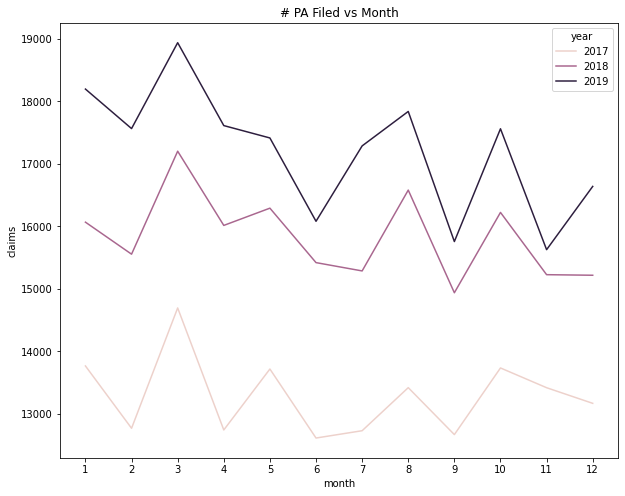

In [513]:
plt.figure(figsize=(10, 8))

sns.lineplot(x='month', y='claims', data=claim_month, hue='year')

plt.title('# PA Filed vs Month')
plt.xticks(range(1, 13), range(1, 13))
plt.show()

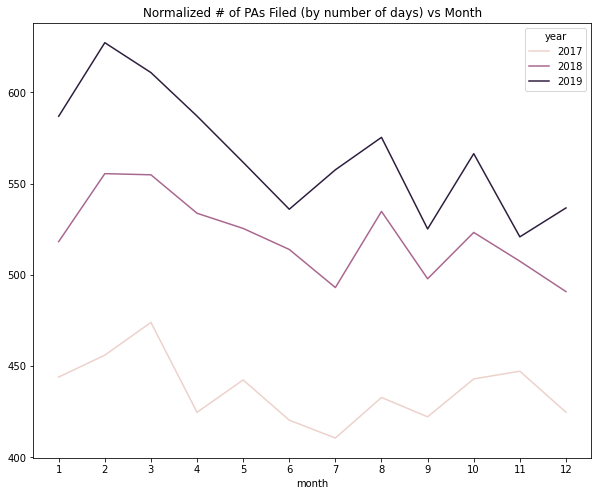

In [514]:
plt.figure(figsize=(10, 8))

sns.lineplot(x=claim_month.month, y=claim_month.claims / claim_month.days, hue=claim_month.year)

plt.title('Normalized # of PAs Filed (by number of days) vs Month')
plt.xticks(range(1, 13), range(1, 13))
plt.show()

## Exponential Smoothing
Exponential smoothing is a method for creating a time series forecast from previous data, where the previous data is assigned an exponentially decreasing weight with age. In other words, recent observations are given more weight in forecasting than the older ones.

More precisely, suppose that the data sequence is given by $\{x_t\}_{t=0}^N$. In the case of the number of PAs filed, $t=0, \dots, 35$ and is the month and $x_t$ is the number of PAs filed in month $t$. If $s_t$ is our prediction via the exponential smoothing algorithm, then the simplest form of exponential smoothing is given by the formulas: 
\begin{align*} s_0 & = x_0 \\
s_t & = \alpha x_t + (1-\alpha)s_{t-1},
\end{align*}
with $t > 0$ and $\alpha$ a smoothing factor with $0 < \alpha < 1$. 




In [515]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

We next choose the forecast horizon.

In [516]:
horizon = 6

In [517]:
months = pd.to_datetime(claim_month.year.astype(str) + '-' + claim_month.month.astype(str))
normalized_claims = claim_month.claims / claim_month.days


X_train = normalized_claims[:-horizon]
X_test = normalized_claims[-horizon:]


def fit_and_plot(model_cls, sims = False, **kwargs):
    model = model_cls(X_train, **kwargs).fit()
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.plot(months[:-horizon], X_train, 'b-', label='train data')
    ax.plot(months[:-horizon], model.fittedvalues, 'r-', label='train forecast')
    
    ax.plot(months[-horizon-1:], [X_train.tolist()[-1]] + X_test.tolist(), 'b--', label='test data')
    ax.plot(
        months[-horizon-1:],
        [model.fittedvalues.tolist()[-1]] + model.forecast(horizon).tolist(),
        'r--', label='test forecast'
    )
    

    
    plt.title(model_cls.__name__)
    plt.legend()
    plt.show()
    
    train_mse = mean_squared_error(X_train, model.fittedvalues)
    test_mse = mean_squared_error(X_test, model.forecast(horizon))
    print(f'Train MSE for {model_cls.__name__}: {train_mse:.2f}')
    print(f'Test MSE for {model_cls.__name__}: {test_mse:.2f}')
    
    return model

def fit_and_plot_uncertainty(model_cls, alpha, **kwargs):
    model = model_cls(X_train, **kwargs).fit()
    start=len(months)-horizon
    simulations = model.simulate(horizon, repetitions=500, anchor=start, error='mul')
    pred_int=create_pi(simulations, alpha)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.plot(months[:-horizon], X_train, 'b-', label='train data')
    ax.plot(months[:-horizon], model.fittedvalues, 'r-', label='train forecast')
    
    ax.plot(months[-horizon-1:], [X_train.tolist()[-1]] + X_test.tolist(), 'b--', label='test data')
    ax.plot(
        months[-horizon-1:],
        [model.fittedvalues.tolist()[-1]] + model.forecast(horizon).tolist(),
        'r--', label='test forecast'
    )
    
    connection=[X_train.tolist()[-1]]
    
    if model_cls==ARIMA:
        ax.plot(months[start-1:], connection+ simulations['y',0].tolist(), 
                '-', alpha=0.07, color='grey', label='Simulation') 
        for i in range(1, 100):
            ax.plot(months[start-1:],connection+ simulations['y',i].tolist(), 
                    '-', alpha=0.07, color='grey')     
    else:
        ax.plot(months[start-1:], connection+ simulations[0].tolist(), 
                '-', alpha=0.07, color='grey', label='simulation')
        for i in range(1, 100):
            ax.plot(months[start-1:], connection+ simulations[i].tolist(), 
                    '-', alpha=0.07, color='grey')
    
    lb=connection+pred_int['lower_bound'].tolist()
    ub=connection+pred_int['upper_bound'].tolist()
    mid=connection+pred_int['middle'].tolist()
    ax.plot(months[start-1:], lb, '--', color='purple', alpha=.5)
    ax.plot(months[start-1:], ub, '--', color='purple', alpha=.5)
    ax.plot(months[start-1:], mid , '--', color='purple', alpha=.5)
    ax.fill_between(months[start-1:], lb , ub , alpha=.05, label='{} Prediction Interval'.format(alpha), color='purple')
    
    plt.title(model_cls.__name__)
    plt.legend()
    plt.show()
    
    train_mse = mean_squared_error(X_train, model.fittedvalues)
    test_mse = mean_squared_error(X_test, model.forecast(horizon))
    PI_u_mse = mean_squared_error(X_test,pred_int['upper_bound'].tolist())
    PI_l_mse=mean_squared_error(X_test,pred_int['lower_bound'].tolist()) 
    
    print(f'Train MSE for {model_cls.__name__}: {train_mse:.2f}')
    print(f'Test MSE for {model_cls.__name__}: {test_mse:.2f}')
    print(f'Upper Bound Prediction Interval MSE for {model_cls.__name__}: {PI_u_mse:.2f}')
    print(f'Lower Bound Prediction Interval MSE for {model_cls.__name__}: {PI_l_mse:.2f}')
    print(np.round(np.sqrt(PI_u_mse)/np.mean(X_train.tolist()[-horizon:])*100,2))
    return model

In [518]:
def fit_and_plot_both(model_cls, alpha = .95, **kwargs):
    model = model_cls(X_train, **kwargs).fit()
    start=len(months)-horizon
    simulations = model.simulate(horizon, repetitions=500, anchor=start, error='mul')
    pred_int=create_pi(simulations, alpha)
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 8))
    
    # first plot
    ax1.plot(months[:-horizon], X_train, 'b-', label='train data')
    ax1.plot(months[:-horizon], model.fittedvalues, 'r-', label='train forecast')
    
    ax1.plot(months[-horizon-1:], [X_train.tolist()[-1]] + X_test.tolist(), 'b--', label='test data')
    ax1.plot(
        months[-horizon-1:],
        [model.fittedvalues.tolist()[-1]] + model.forecast(horizon).tolist(),
        'r--', label='test forecast'
    )
    
    ax1.set_title('forecast')
    
    ax1.tick_params(axis='x', labelrotation = 45)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('# PAs Filed')
    
    ax1.legend()
    
    # second plot
    ax2.plot(months[:-horizon], X_train, 'b-', label='train data')
    ax2.plot(months[:-horizon], model.fittedvalues, 'r-', label='train forecast')
    ax2.plot(months[-horizon-1:], [X_train.tolist()[-1]] + X_test.tolist(), 'b--', label='test data')
    
    connection=[model.fittedvalues.tolist()[-1]]
    
    if model_cls==ARIMA:
        ax2.plot(months[start-1:], connection+ simulations['y',0].tolist(), 
                '-', alpha=0.07, color='grey', label='Simulation') 
        for i in range(1, 100):
            ax2.plot(months[start-1:],connection+ simulations['y',i].tolist(), 
                    '-', alpha=0.07, color='grey')     
    else:
        ax2.plot(months[start-1:], connection+ simulations[0].tolist(), 
                '-', alpha=0.07, color='grey', label='simulation')
        for i in range(1, 100):
            ax2.plot(months[start-1:], connection+ simulations[i].tolist(), 
                    '-', alpha=0.07, color='grey')
    
    lb=connection+pred_int['lower_bound'].tolist()
    ub=connection+pred_int['upper_bound'].tolist()
    mid=connection+pred_int['middle'].tolist()
    ax2.plot(months[start-1:], lb, '--', color='purple', alpha=.5)
    ax2.plot(months[start-1:], ub, '--', color='purple', alpha=.5)
    ax2.plot(months[start-1:], mid , '--', color='purple', alpha=.5)
    ax2.fill_between(months[start-1:], lb , ub , alpha=.05, label='{} Prediction Interval'.format(alpha), color='purple')
    ax2.tick_params(axis='x', labelrotation = 45)
    ax2.legend()
    ax2.set_title('forecast Prediction Interval')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('# PAs Filed')
    
    fig.suptitle(model_cls.__name__)
    
    
    # print errors 
    
    train_mse = mean_squared_error(X_train, model.fittedvalues)
    test_mse = mean_squared_error(X_test, model.forecast(horizon))
    PI_u_mse = mean_squared_error(X_test,pred_int['upper_bound'].tolist())
    PI_l_mse=mean_squared_error(X_test,pred_int['lower_bound'].tolist()) 
    
    print(f'Train MSE for {model_cls.__name__}: {train_mse:.2f}')
    print(f'Test MSE for {model_cls.__name__}: {test_mse:.2f}')
    print(f'Upper Bound Prediction Interval MSE for {model_cls.__name__}: {PI_u_mse:.2f}')
    print(f'Lower Bound Prediction Interval MSE for {model_cls.__name__}: {PI_l_mse:.2f}')
    
    avg_error = (np.round(np.sqrt(PI_u_mse)/np.mean(X_train.tolist()[-horizon:])*100,2) + np.round(np.sqrt(PI_l_mse)/np.mean(X_train.tolist()[-horizon:])*100,2))/2
    
    avg_error=np.round(avg_error, 2)
    print()
    print('---------------------------------------------------------')
    print('There is a', alpha*100, '% chance that our forecast will be within', avg_error, '% of the true # of PAs filed monthly.')
    
    

### Simple Exponential Smoothing

Train MSE for SimpleExpSmoothing: 1126.80
Test MSE for SimpleExpSmoothing: 533.14
Upper Bound Prediction Interval MSE for SimpleExpSmoothing: 20789.43
Lower Bound Prediction Interval MSE for SimpleExpSmoothing: 18007.77

---------------------------------------------------------
There is a 95.0 % chance that our forecast will be within 23.8 % of the true # of PAs filed monthly.


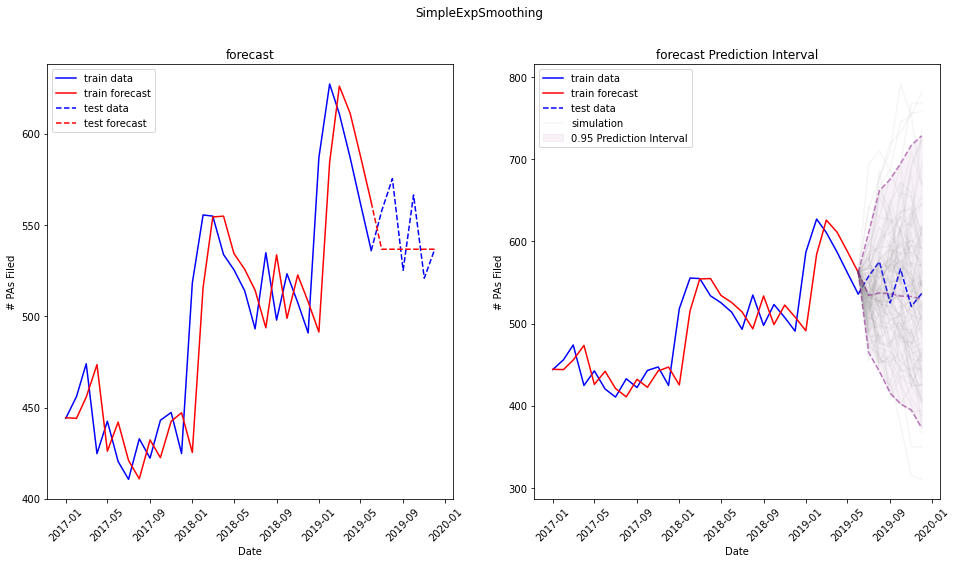

In [519]:
fit_and_plot_both(SimpleExpSmoothing, alpha= .95)

### Holt's Method


Train MSE for Holt: 1116.23
Test MSE for Holt: 579.77
Upper Bound Prediction Interval MSE for Holt: 24167.65
Lower Bound Prediction Interval MSE for Holt: 16737.92

---------------------------------------------------------
There is a 95.0 % chance that our forecast will be within 24.35 % of the true # of PAs filed monthly.


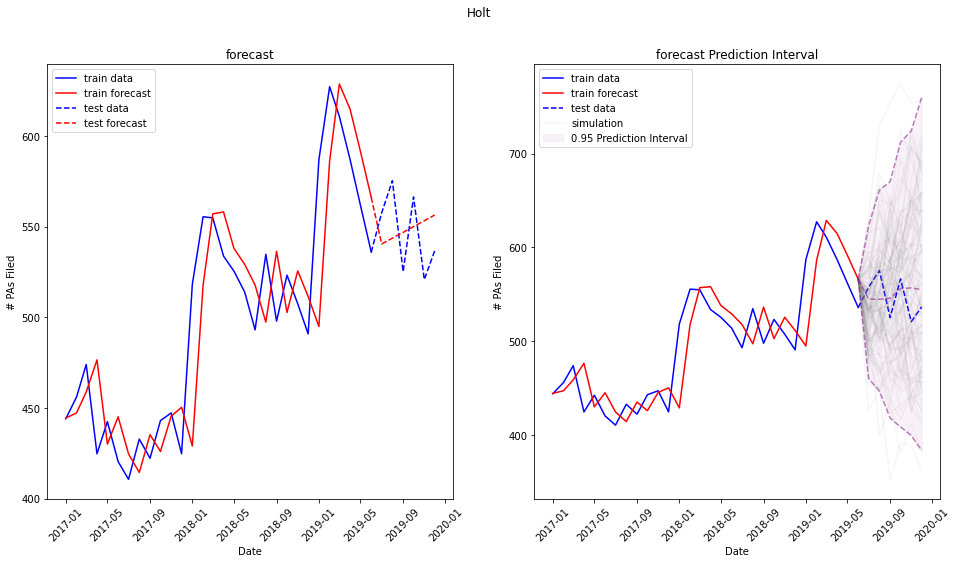

In [520]:
fit_and_plot_both(Holt, damped_trend=False)


Train MSE for Holt: 1115.73
Test MSE for Holt: 533.53
Upper Bound Prediction Interval MSE for Holt: 25172.31
Lower Bound Prediction Interval MSE for Holt: 17550.68

---------------------------------------------------------
There is a 95.0 % chance that our forecast will be within 24.88 % of the true # of PAs filed monthly.


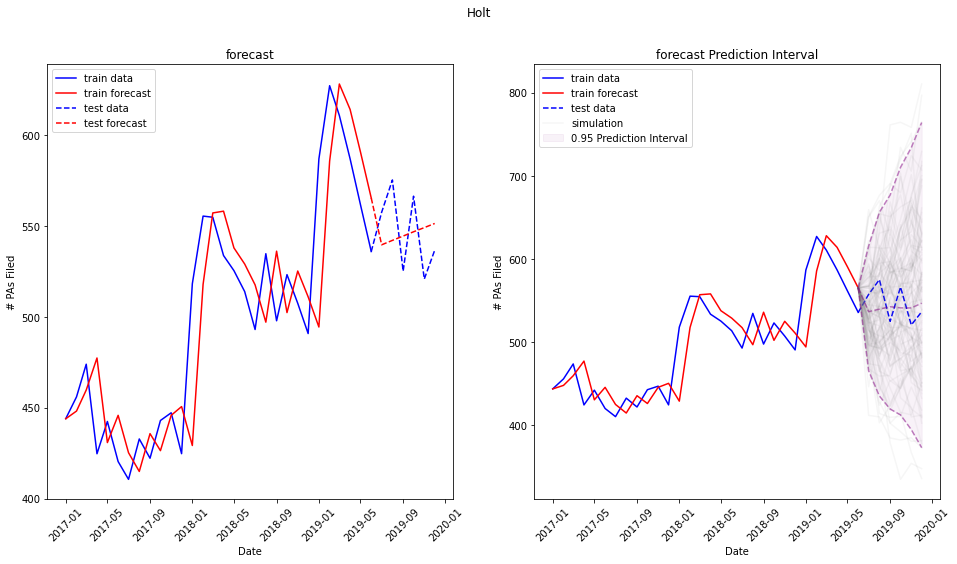

In [521]:
fit_and_plot_both(Holt, damped_trend=True)
None

Train MSE for ExponentialSmoothing: 85.75
Test MSE for ExponentialSmoothing: 391.29
Upper Bound Prediction Interval MSE for ExponentialSmoothing: 2187.47
Lower Bound Prediction Interval MSE for ExponentialSmoothing: 1619.35

---------------------------------------------------------
There is a 95.0 % chance that our forecast will be within 7.44 % of the true # of PAs filed monthly.


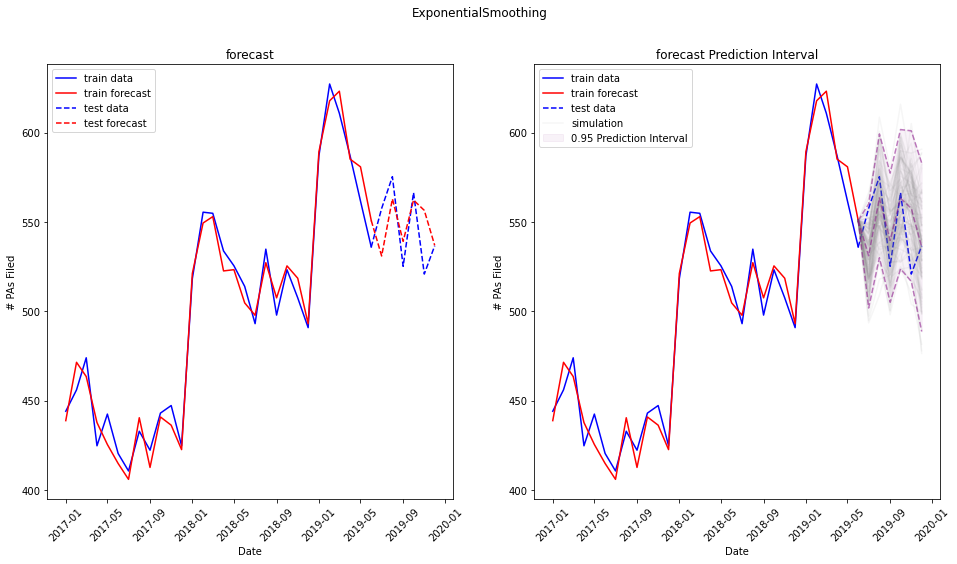

In [522]:
fit_and_plot_both(ExponentialSmoothing, trend='add', seasonal='add', seasonal_periods=12)
None

Train MSE for ExponentialSmoothing: 85.75
Test MSE for ExponentialSmoothing: 391.29
Upper Bound Prediction Interval MSE for ExponentialSmoothing: 2292.70
Lower Bound Prediction Interval MSE for ExponentialSmoothing: 1675.38

---------------------------------------------------------
There is a 95.0 % chance that our forecast will be within 7.6 % of the true # of PAs filed monthly.


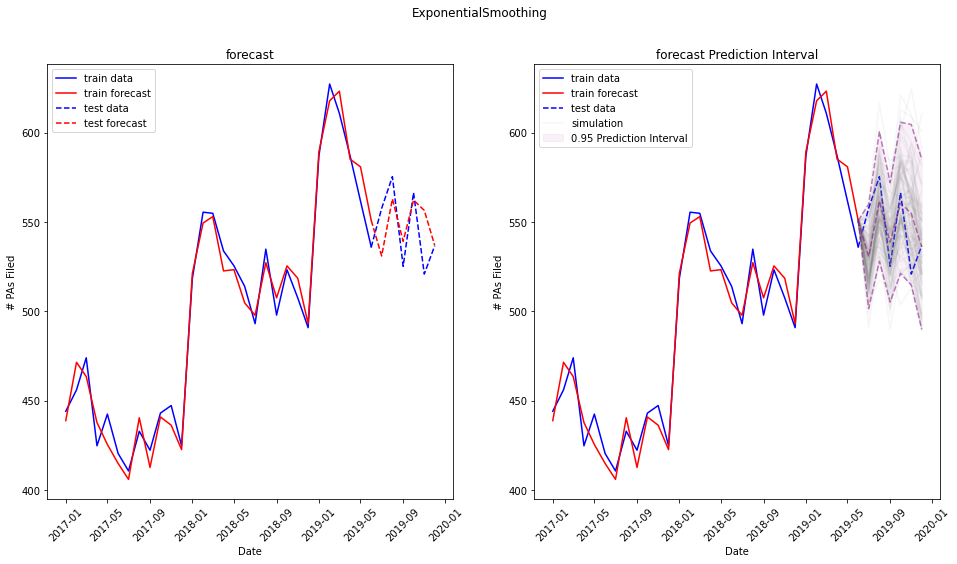

In [523]:
fit_and_plot_both(ExponentialSmoothing, alpha=.95, trend='add', seasonal='add', seasonal_periods=12)

Train MSE for ExponentialSmoothing: 63.18
Test MSE for ExponentialSmoothing: 276.43
Upper Bound Prediction Interval MSE for ExponentialSmoothing: 914.13
Lower Bound Prediction Interval MSE for ExponentialSmoothing: 981.51

---------------------------------------------------------
There is a 95.0 % chance that our forecast will be within 5.26 % of the true # of PAs filed monthly.


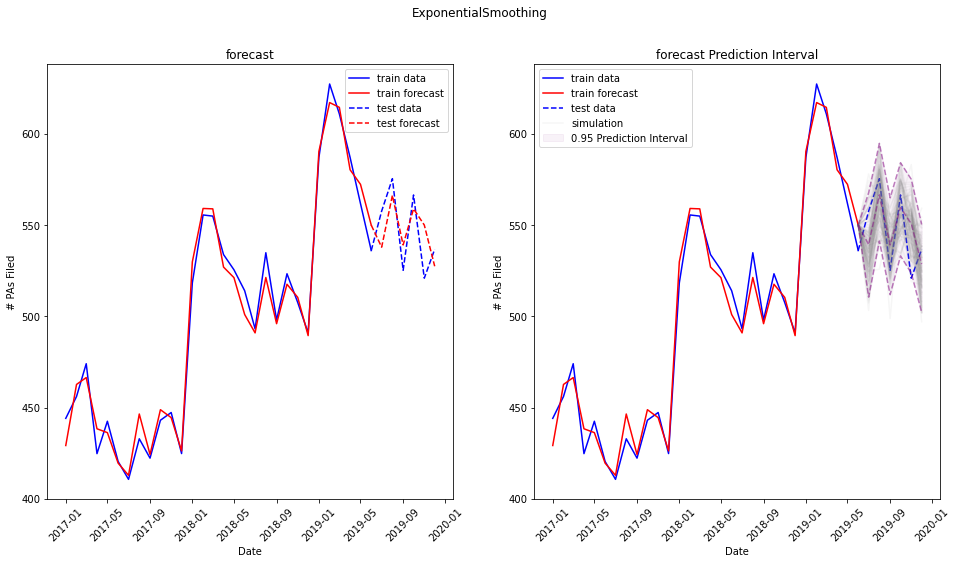

In [524]:
fit_and_plot_both(
    ExponentialSmoothing, 
    trend='add', damped_trend=True,
    seasonal='add', seasonal_periods=12
)


Train MSE for ExponentialSmoothing: 85.75
Test MSE for ExponentialSmoothing: 391.29
Upper Bound Prediction Interval MSE for ExponentialSmoothing: 2296.09
Lower Bound Prediction Interval MSE for ExponentialSmoothing: 1876.27

---------------------------------------------------------
There is a 95.0 % chance that our forecast will be within 7.8 % of the true # of PAs filed monthly.


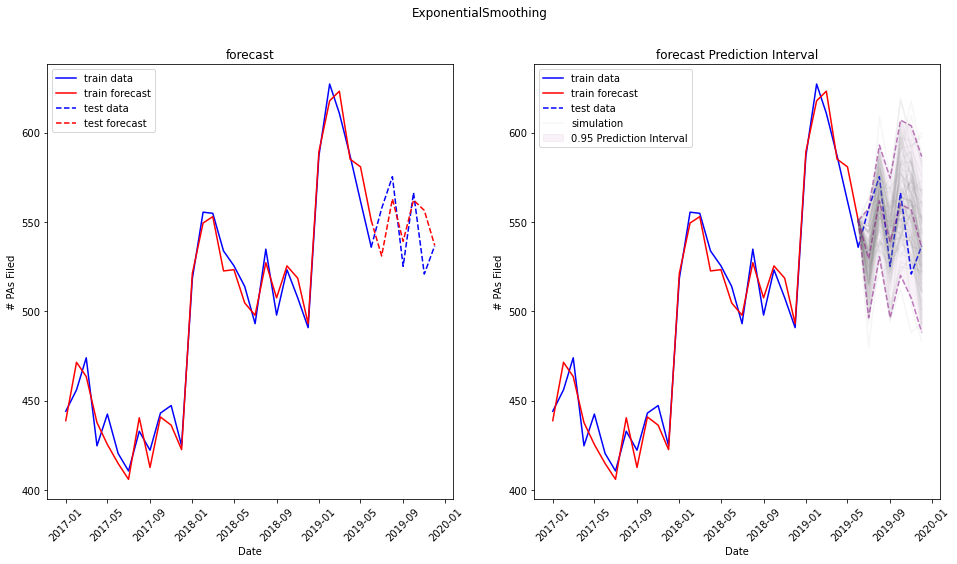

In [525]:
fit_and_plot_both(
    ExponentialSmoothing, alpha=.95,
    trend='add', damped_trend=False,
    seasonal='add', seasonal_periods=12
)

Train MSE for ExponentialSmoothing: 79.31
Test MSE for ExponentialSmoothing: 402.58
Upper Bound Prediction Interval MSE for ExponentialSmoothing: 2041.27
Lower Bound Prediction Interval MSE for ExponentialSmoothing: 2239.33

---------------------------------------------------------
There is a 95.0 % chance that our forecast will be within 7.9 % of the true # of PAs filed monthly.


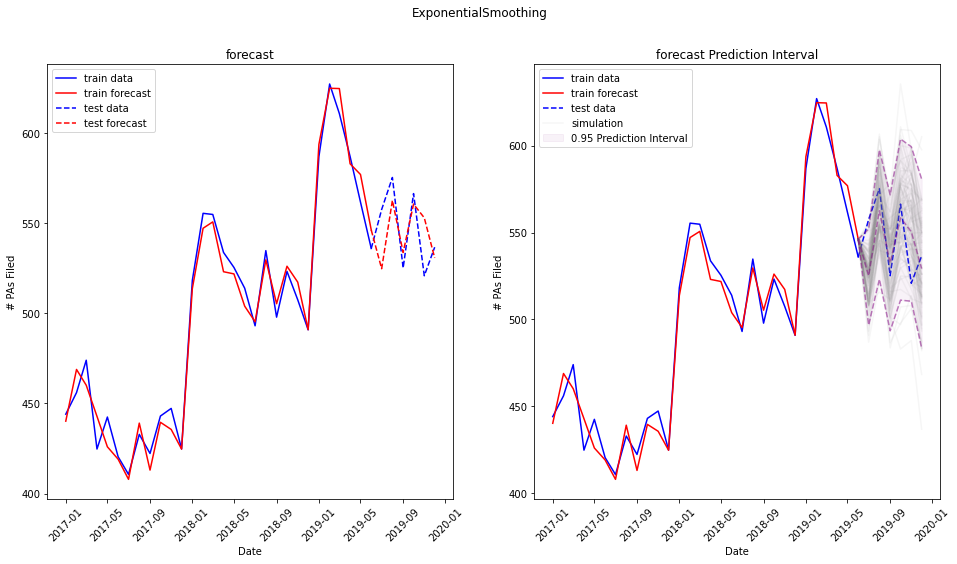

In [526]:
fit_and_plot_both(
    ExponentialSmoothing,
    trend='mul',
    seasonal='mul', damped=False, seasonal_periods=12, alpha = .95
)

Train MSE for ExponentialSmoothing: 67.19
Test MSE for ExponentialSmoothing: 786.58
Upper Bound Prediction Interval MSE for ExponentialSmoothing: 882.97
Lower Bound Prediction Interval MSE for ExponentialSmoothing: 2381.81

---------------------------------------------------------
There is a 95.0 % chance that our forecast will be within 6.71 % of the true # of PAs filed monthly.


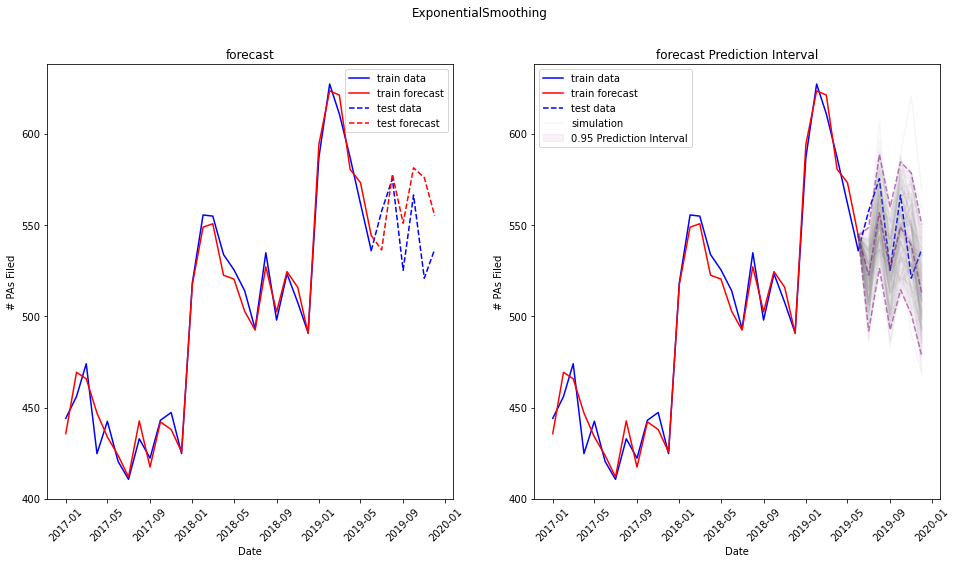

In [527]:
fit_and_plot_both(
    ExponentialSmoothing,
    trend='mul',
    seasonal='mul', damped=True, seasonal_periods=12, alpha = .95
)

### Cross Validation

In [528]:
import itertools

def check_param(param, param_list):
    if param['trend'] is None and param['damped_trend']:
        return
    if param['seasonal'] is None and param['seasonal_periods'] is not None:
        return
    if param['seasonal'] is not None and param['seasonal_periods'] is None:
        return
    param_list.append(param)

def get_param_list(param_grid):
    keys = list(param_grid.keys())
    vals = [param_grid[k] for k in keys]
    params = list(dict(zip(keys, param)) for param in itertools.product(*vals))
    ret = []
    for param in params:
        check_param(param, ret)
    return ret

In [529]:
param_grid = {
    'trend': [None, 'add', 'mul'],
    'damped_trend': [False, True],
    'seasonal': [None, 'add', 'mul'],
    'seasonal_periods': [None, 3, 6, 9, 12]
}


param_list = get_param_list(param_grid)
idx = np.arange(30)
splits = [
    (idx[:k], idx[k:k+3])
    for k in range(24, 30)
]

In [530]:
mses = np.zeros((len(splits), len(param_list)))

for i, (train_idx, test_idx) in enumerate(splits):
    xx_train, xx_test = X_train[train_idx], X_train[test_idx]
    for j, param in enumerate(param_list):
        fit = ExponentialSmoothing(xx_train, **param).fit(optimized=True)
        mses[i, j] = mean_squared_error(xx_test, fit.forecast(len(xx_test)))
mses = mses.mean(axis=1)

In [531]:
k = mses.argmin()
print(f'Best parameters: {param_list[k]}')

Best parameters: {'trend': None, 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 12}


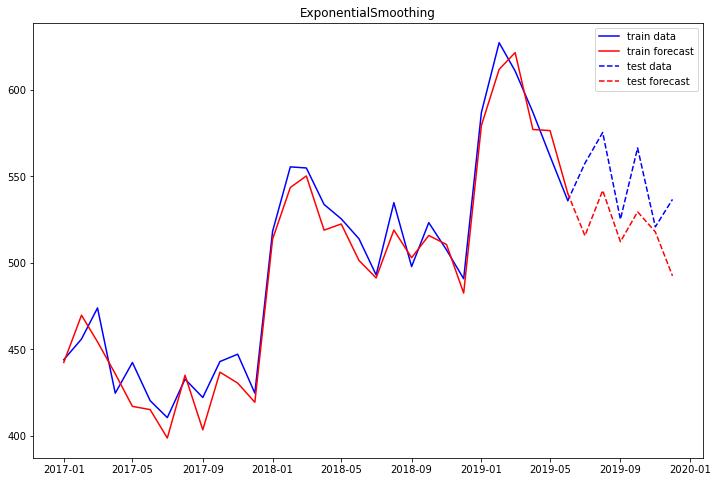

Train MSE for ExponentialSmoothing: 131.02
Test MSE for ExponentialSmoothing: 1061.08


In [532]:
fit_model_and_plot(ExponentialSmoothing, **param_list[k])
None

Cross validation gives a very different set of parameters than my own exploration.

|  | Cross Validation | Exploration |
| --- | --- | --- |
| trend | None | add |
| damped_trend | False | True |
| seasonal | mul | add |
| seasonal_periods | 3 | 12 |
| train MSE | 5569.60 | 331.03 |
| test MSE | 1718.76 | 1069.72 |

### Constructing Prediction Intervals
The prediction intervals will be constructed via the statsmodels.tsa simulate function. 

Note that while prediction intervals are similar to confidence intervals, they are not the same. Confidence intervals are estimates that are calculated from sample data to determine intervals that are likely to contain the population parameter. On the other hand, a prediction interval is an interval that likely contains the value of a dependent variable for a new observation, given other values of the independent variable. 

The procedure for constructing confidence intervals and prediction intervals are similar. More precisely, we do the following:
1. Simulate the data N times from a state space determined by the data;
2. from each simulation, create a forcase;
3. take the middle $95\%$ of forecast values to create a $95\%$ prediction interval. 





In [533]:
def create_pi(sims, alpha):
    # sims is a pd series that contains simulation data in each column with the month in each row. 
    num_months = np.shape(sims)[0]
    num_sims=np.shape(sims)[1]
    con_ints=np.zeros((num_months,4))
    for i in range(0, num_months):
        data=sims.loc[36-num_months+i]
        p = ((1.0-alpha)/2.0) * 100
        con_ints[i,0] = np.percentile(data, p)
        p = (alpha+((1.0-alpha)/2.0)) * 100
        con_ints[i,1]=np.percentile(data, 50)
        con_ints[i,2] = np.percentile(data, p)
        con_ints[i,3]=36-num_months+i
    new_df=pd.DataFrame(data=con_ints, columns=['lower_bound', 'middle', 'upper_bound', 'month'] )
    return new_df


## ARIMA

In [534]:
from statsmodels.tsa.arima.model import ARIMA

modl=ARIMA(X_train)

sims=modl.simulate(nsimulations=4, repetitions=100,  error='add', params=(0, 1, 1, 12))

sims.loc[1]

y  0     1.784354
   1     1.271936
   2    -1.684218
   3     0.624732
   4     0.040752
           ...   
   95   -1.832384
   96    1.078236
   97    1.097708
   98    0.736352
   99    0.477455
Name: 1, Length: 100, dtype: float64

Train MSE for ARIMA: 79364.17
Test MSE for ARIMA: 202.82
Upper Bound Prediction Interval MSE for ARIMA: 15403.78
Lower Bound Prediction Interval MSE for ARIMA: 14547.50

---------------------------------------------------------
There is a 95.0 % chance that our forecast will be within 20.92 % of the true # of PAs filed monthly.


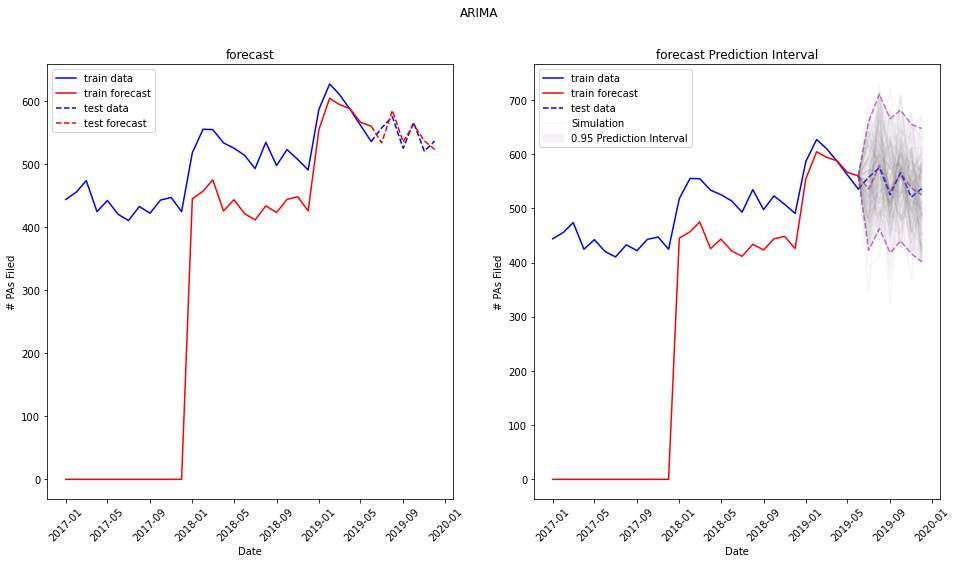

In [535]:
fit_and_plot_both(ARIMA, seasonal_order=(0, 1, 1, 12))


In [536]:
param_list = list(
    itertools.product(
        range(0, 2), # P
        range(0, 2), # D
        range(0, 2), # Q
        [3, 6, 9, 12], # S
    )
)
idx = np.arange(30)
splits = [
    (idx[:k], idx[k:k+3])
    for k in range(24, 30)
]

mses = np.zeros((len(splits), len(param_list)))

for i, (train_idx, test_idx) in enumerate(splits):
    xx_train, xx_test = X_train[train_idx], X_train[test_idx]
    for j, param in enumerate(param_list):
        fit = ARIMA(xx_train, seasonal_order=param).fit()
        mses[i, j] = mean_squared_error(xx_test, fit.forecast(len(xx_test)))
mses = mses.mean(axis=1)

In [537]:
k = mses.argmin()
print(f'Best parameter for seasonal_order in ARIMA: {param_list[k]}')

Best parameter for seasonal_order in ARIMA: (0, 0, 1, 6)


Train MSE for ARIMA: 3565.44
Test MSE for ARIMA: 1294.60
Upper Bound Prediction Interval MSE for ARIMA: 7106.29
Lower Bound Prediction Interval MSE for ARIMA: 20009.67

---------------------------------------------------------
There is a 95.0 % chance that our forecast will be within 19.3 % of the true # of PAs filed monthly.


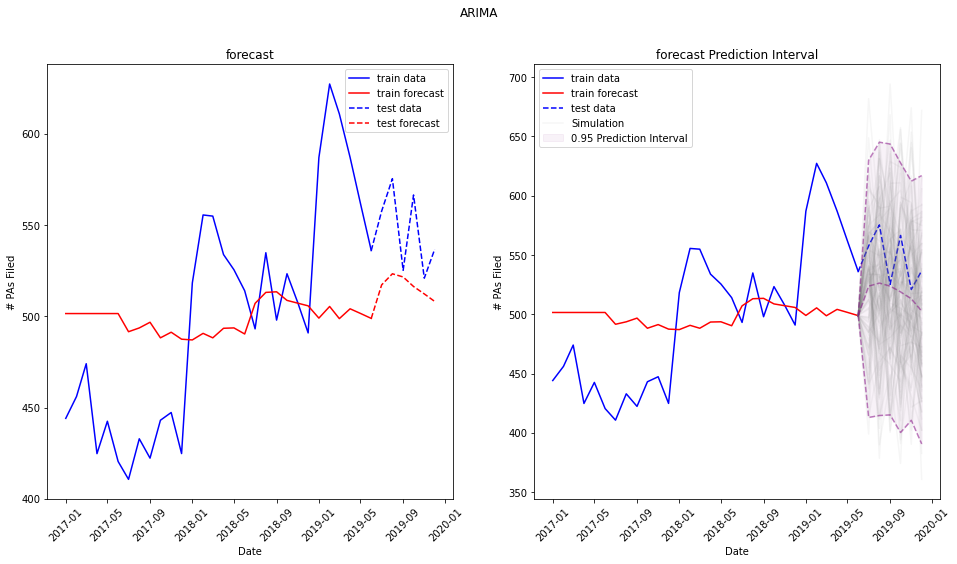

In [538]:
fit_and_plot_both(ARIMA, alpha=.95, seasonal_order=param_list[k])
None